<a href="https://colab.research.google.com/github/Frederick-Stein/Data-Science-Playground/blob/main/Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import TextVectorization

from collections import Counter

In [2]:
seed = 42
## get data
url = 'https://raw.githubusercontent.com/Frederick-Stein/Data-Science-Playground/refs/heads/main/Projects/Spam_Detection/spam_ham_dataset.csv'
data = pd.read_csv(url)
print(data.shape)
data.head()

(5171, 4)


,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0


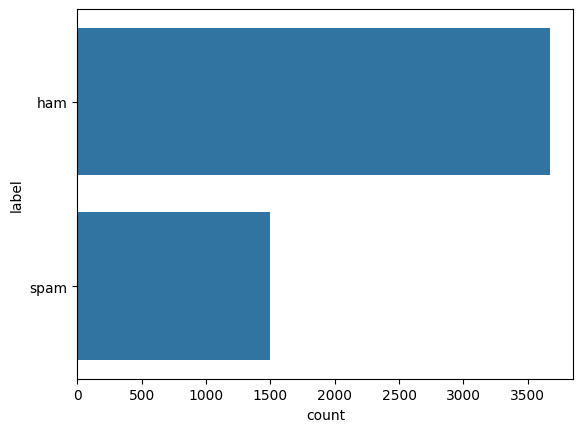

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [3]:
## EDA
sns.countplot(data['label'])
plt.show()
data.info()

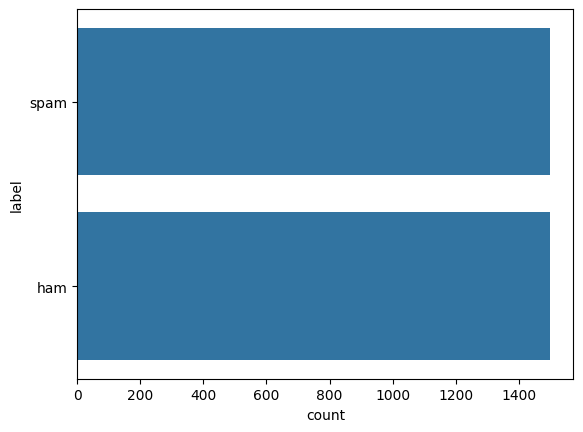

In [4]:
# balance (undersampling) (optional)
data_ham = data[data['label'] == 'ham']
data_spam = data[data['label'] == 'spam']

data_ham_undersampled = data_ham.sample(n=len(data_spam), random_state=seed)
data_balanced = pd.concat([data_spam, data_ham_undersampled]).reset_index(drop=True)

sns.countplot(data_balanced['label'])
plt.show()

In [5]:
## base model
# unbalanced data
X = data['text']
y = data['label_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# encoding
vec = TfidfVectorizer(stop_words = 'english', lowercase = True)
X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)

# fit baseline model
baseline_model = MultinomialNB()
baseline_model.fit(X_train,y_train)
print(f"Accuracy of baseline model with unbalanced data: {accuracy_score(y_test,baseline_model.predict(X_test)): .4f}")
print(classification_report(y_test,baseline_model.predict(X_test)))

Accuracy of baseline model with unbalanced data:  0.9237
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       742
           1       1.00      0.73      0.84       293

    accuracy                           0.92      1035
   macro avg       0.95      0.87      0.90      1035
weighted avg       0.93      0.92      0.92      1035



In [6]:
# balanced data
X = data_balanced['text']
y = data_balanced['label_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# emcoding
vec = TfidfVectorizer(stop_words = 'english', lowercase = True)
X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)

# fit baseline model
baseline_model = MultinomialNB()
result = baseline_model.fit(X_train,y_train)
print(f"Accuracy of baseline model with balanced data: {accuracy_score(y_test,baseline_model.predict(X_test)): .4f}")
print(classification_report(y_test,baseline_model.predict(X_test)))

Accuracy of baseline model with balanced data:  0.9667
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       285
           1       0.97      0.97      0.97       315

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



In [7]:
## deep learning with LSTM using tensorflow

# get the length of text
length = [len(x.split()) for x in data['text']]
output_length = round(np.percentile(length, 80))
print("80th percentile of lengths:", output_length)
# get number of tokens
s = set()
for text in data['text']:
  for word in text.split():
    s.add(word.lower())
num_tokens=len(s)
print("Number of tokens:", num_tokens)
# get tokens that appear more than once
tokens = " ".join(data['text']).lower().split()
freqs = Counter(tokens)
freqs_1 = {k:v for k,v in freqs.items() if v > 1}
num_tokens = len(freqs_1)
print("Number of tokens that appear more than once:", num_tokens)

80th percentile of lengths: 337
Number of tokens: 50615
Number of tokens that appear more than once: 24184


In [32]:
# balanced data
X = data_balanced['text']
y = data_balanced['label_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# encoding using TextVectorization
text_vec = TextVectorization(max_tokens=num_tokens,
                        standardize="lower",
                        output_mode='int',
                        output_sequence_length=300
                        )
text_vec.adapt(X_train)
X_train = text_vec(X_train)
X_test = text_vec(X_test)

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8093 - loss: 0.6549 - val_accuracy: 0.9300 - val_loss: 0.4212
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9433 - loss: 0.3843 - val_accuracy: 0.9433 - val_loss: 0.3079
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9735 - loss: 0.2675 - val_accuracy: 0.9667 - val_loss: 0.2738
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9869 - loss: 0.2444 - val_accuracy: 0.9817 - val_loss: 0.2600
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9908 - loss: 0.2266 - val_accuracy: 0.9817 - val_loss: 0.2511


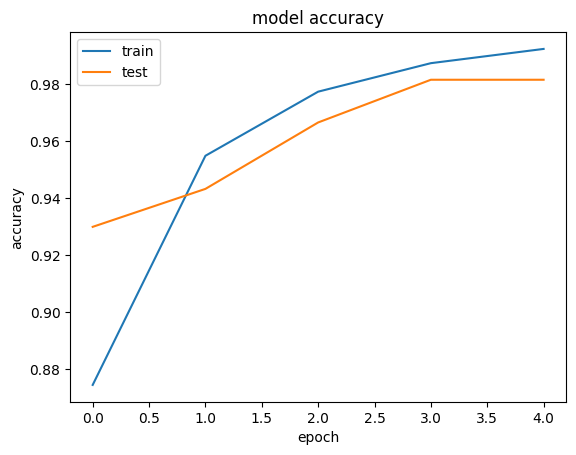

In [64]:
# fit a base model
base_model = keras.Sequential([
    layers.Embedding(input_dim=num_tokens, output_dim=32, mask_zero=True),
    layers.GlobalAveragePooling1D(), # compress sequence
    layers.Flatten(),
    # layers.LSTM(32),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
base_model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(label_smoothing=0.1), metrics=['accuracy'])

# evaluation
result_1 = base_model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

plt.plot(result_1.history['accuracy'])
plt.plot(result_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.6957 - loss: 0.5779 - val_accuracy: 0.9600 - val_loss: 0.2697
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9850 - loss: 0.2409 - val_accuracy: 0.9783 - val_loss: 0.2411
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9974 - loss: 0.2104 - val_accuracy: 0.9800 - val_loss: 0.2350
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9968 - loss: 0.2070 - val_accuracy: 0.9750 - val_loss: 0.2462
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9984 - loss: 0.2048 - val_accuracy: 0.9717 - val_loss: 0.2537


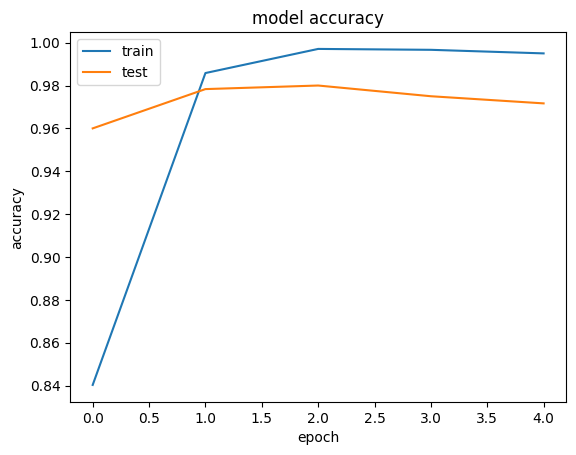

In [65]:
# fit a LSTM model
lstm_model = keras.Sequential([
    layers.Embedding(input_dim=num_tokens, output_dim=32, mask_zero=True),
    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(label_smoothing=0.1), metrics=['accuracy'])

# evaluation
result_2 = lstm_model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

plt.plot(result_2.history['accuracy'])
plt.plot(result_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()